# Simple Exemple of Data Analysis using Pandas

This notebook is an exemple of simple data analysis using Python and the Pandas library.

**Dataset analysed:** Real estate transactions on the French market from 2014 to 2019

**Source:** https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/

Structure of this notebook:
- Step n°1: Data Ingestion
- Step n°2: Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # display all the columns of the dataframes

# Step n°1: Data Ingestion

In [2]:
# Load raw data from the CSV files
# Remarks:
#  - We load data as `str` since we don't want pandas to guess the data types.
#    Indeed, if the data are updated and contain mistakes, pandas may choose to use another
#    data types and errors would happend later during the analysis. In order to keep the
#    loading operation idempotent, we'll set the data types later.
#  - We compare the number of rows and columns between the original files and the
#    dataframes loaded by pandas. By doing that, we prevent (partially) the risk of
#    columns shift and data loss. To fully prevent this risk, the CSV files can be
#    audited using this Python script: https://github.com/benjamindelmee/safe-csv
#  - It's also possible to merge the CSV files using a "good old batch script". Batch
#    concatenation is faster but often tends to not be documented. Here, we keep track
#    in the same script of all the operations done on the data.

raw2019 = pd.read_csv(
    './data/valeursfoncieres-2019.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2019.shape[0] == 1017154
assert raw2019.shape[1] == 43

raw2018 = pd.read_csv(
    './data/valeursfoncieres-2018.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2018.shape[0] == 3059537
assert raw2018.shape[1] == 43

raw2017 = pd.read_csv(
    './data/valeursfoncieres-2017.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2017.shape[0] == 3376523
assert raw2017.shape[1] == 43

raw2016 = pd.read_csv(
    './data/valeursfoncieres-2016.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2016.shape[0] == 2937694
assert raw2016.shape[1] == 43

raw2015 = pd.read_csv(
    './data/valeursfoncieres-2015.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2015.shape[0] == 2750121
assert raw2015.shape[1] == 43

raw2014 = pd.read_csv(
    './data/valeursfoncieres-2014.txt'
    , sep='|'
    , header=0
    , low_memory=False
    , dtype=str
)
assert raw2014.shape[0] == 2516802
assert raw2014.shape[1] == 43

In [3]:
# Add origin of the datasets
# Remarks:
# - The field added/computed during the analysis are prefixed with "!"
raw2014['!Source file'] = 'vf-2014'
raw2015['!Source file'] = 'vf-2015'
raw2016['!Source file'] = 'vf-2016'
raw2017['!Source file'] = 'vf-2017'
raw2018['!Source file'] = 'vf-2018'
raw2019['!Source file'] = 'vf-2019'

# Merge the files
# Remarks:
# - We check that the operation didn't alter the dataset
raw = pd.concat([raw2014, raw2015, raw2016, raw2017, raw2018, raw2019])
assert raw.shape[0] == (raw2014.shape[0] + raw2015.shape[0] + raw2016.shape[0] + raw2017.shape[0] + raw2018.shape[0] + raw2019.shape[0])

# Remove unused raw files
# Remarks:
# - We won't use those dataframes anymore so we free the memory
del raw2014
del raw2015
del raw2016
del raw2017
del raw2018
del raw2019

In [4]:
# Remove empty columns
# Remarks:
# - The dataset contains empty columns (by design) so we remove them to not pollute
#   the analysis.
# - Before removing columns, we always check they are empty

cols_to_remove = [
    'Code service CH',
    'Reference document',
    '1 Articles CGI',
    '2 Articles CGI',
    '3 Articles CGI',
    '4 Articles CGI',
    '5 Articles CGI',
    'Identifiant local'
]

for col in cols_to_remove:
    assert raw[col].count() == 0

raw.drop(inplace=True, columns=cols_to_remove)

In [5]:
# Cast columns to the right types
# Remarks:
# - By casting the columns by ourselves, we ensure we have a full control on the types
#   and that we'll detect all the flaws before running the analysis. Also, since we use
#   more adapted types (for exemple uint32 instead of float64 when possible), this result
#   in less memory consumption.
# - We check if we have lost data during casting

raw['No disposition'] = raw['No disposition'].fillna(-1).astype('int16').max()
assert raw['No disposition'].max() != np.iinfo(np.int16).max

raw['Date mutation'] = pd.to_datetime(raw['Date mutation'], format='%d/%m/%Y')

raw['Nature mutation'] = raw['Nature mutation'].astype('category')

raw['Valeur fonciere'] = raw['Valeur fonciere'].replace(',', '.', regex=True).astype('float64')

raw['No voie'] = raw['No voie'].fillna(-1).astype('int16')
assert raw['No voie'].max() != np.iinfo(np.int16).max

raw['B/T/Q'] = raw['B/T/Q'].astype('category')

raw['Type de voie'] = raw['Type de voie'].astype('category')

raw['Code voie'] = raw ['Code voie'].astype('category')

raw['Voie'] = raw ['Voie'].astype('category')

raw['Code postal'] = raw['Code postal'].astype('category')

raw['Commune'] = raw['Commune'].astype('category')

raw['Code departement'] = raw['Code departement'].astype('category')

raw['Code commune'] = raw['Code commune'].astype('category')

raw['Prefixe de section'] = raw['Prefixe de section'].astype('category')

raw['Section'] = raw['Section'].astype('category')

raw['No plan'] = raw['No plan'].astype('uint16')
assert raw['No plan'].max() != np.iinfo(np.uint16).max

raw['No Volume'] = raw['No Volume'].astype('category')

raw['1er lot'] = raw['1er lot'].astype('category')

raw['Surface Carrez du 1er lot'] = raw['Surface Carrez du 1er lot'].replace(',', '.', regex=True).astype('float16')
assert raw['Surface Carrez du 1er lot'].max() != np.inf

raw['2eme lot'] = raw['2eme lot'].astype('category')

raw['Surface Carrez du 2eme lot'] = raw['Surface Carrez du 2eme lot'].replace(',', '.', regex=True).astype('float16')
assert raw['Surface Carrez du 2eme lot'].max() != np.inf

raw['3eme lot'] = raw['3eme lot'].astype('category')

raw['Surface Carrez du 3eme lot'] = raw['Surface Carrez du 3eme lot'].replace(',', '.', regex=True).astype('float16')
assert raw['Surface Carrez du 3eme lot'].max() != np.inf

raw['4eme lot'] = raw['4eme lot'].astype('category')

raw['Surface Carrez du 4eme lot'] = raw['Surface Carrez du 4eme lot'].replace(',', '.', regex=True).astype('float16')
assert raw['Surface Carrez du 4eme lot'].max() != np.inf

raw['5eme lot'] = raw['5eme lot'].astype('category')

raw['Surface Carrez du 5eme lot'] = raw['Surface Carrez du 5eme lot'].replace(',', '.', regex=True).astype('float16')
assert raw['Surface Carrez du 5eme lot'].max() != np.inf

raw['Nombre de lots'] = raw['Nombre de lots'].astype('float16')
assert raw['Nombre de lots'].max() != np.inf

raw['Code type local'] = raw['Code type local'].fillna(-1).astype('int16')
assert raw['Code type local'].max() != np.iinfo(np.int16).max

raw['Type local'] = raw['Type local'].astype('category')

raw['Surface reelle bati'] = raw['Surface reelle bati'].replace(',', '.', regex=True).astype('float32')
assert raw['Surface reelle bati'].max() != np.inf

raw['Nombre pieces principales'] = raw['Nombre pieces principales'].astype('float16')
assert raw['Nombre pieces principales'].max() != np.inf

raw['Nature culture'] = raw['Nature culture'].astype('category')

raw['Nature culture speciale'] = raw['Nature culture speciale'].astype('category')

raw['Surface terrain'] = raw['Surface terrain'].replace(',', '.', regex=True).astype('float32')
assert raw['Surface terrain'].max() != np.inf

raw['!Source file'] = raw['!Source file'].astype('category')

# Step n°2: Data Analysis

In [6]:
# Columns used to create a unique ID per transaction
# Remarks:
# - Some exemples are shown to justify the choice of the columns

demo = False

if demo:
    # Two adresses in the same transaction. The flat is huge and is located in two
    # streets at the same time.
    # => Don't use street-related data to identify transactions
    raw[
        raw.Commune.str.contains('PARIS 16')
        & (
            raw['Date mutation'] == pd.Timestamp(2018, 8, 6)
        )
        & raw['Section'].str.contains('DQ')

    ]

if demo:
    # Rows duplicated because the transaction has two `nature de culture` and
    # two 'locaux', hence 2*2 = 4 rows for the same transaction.
    # => A transaction can have duplicated rows
    raw[
        raw.Commune.str.contains('NIVIGNE ET SURAN')
        & (
            raw['Date mutation']== pd.Timestamp(2018, 1, 4)
        )
        & raw['Section'].str.contains('AH')

    ]

tx_index = ["Date mutation",
            "Valeur fonciere",
            "Code departement",
            "Code commune",
            "Section"]

In [7]:
# Quantify data quality
# Remarks:
# - Some rows contains missing data and can't linked to any transaction. So we quantify
#   the number of lines impacted to know how much the analysis will be impacted.
# - In the worst case (year 2015) 1.47% of the lines can't be linked to any transaction.

def missing_values(series):
    return 1 - series.count() / series.shape[0]

def not_zero_red(value):
    return 'color: red' if value != 0 else 'color: black'

assert raw['Date mutation'].notna().all()
raw[tx_index].groupby(raw['Date mutation'].dt.year).aggregate([missing_values]) \
    .style.applymap(not_zero_red)

,Date mutation,Valeur fonciere,Code departement,Code commune,Section
,missing_values,missing_values,missing_values,missing_values,missing_values
Date mutation,,,,,
2014,0,0.000131516,0,0,4.37063e-05
2015,0,0.0146964,0,0,2.109e-05
2016,0,0.0119631,0,0,3.60827e-05
2017,0,0.0133818,0,0,3.34664e-05
2018,0,0.00918995,0,0,2.84357e-05
2019,0,0.0125694,0,0,2.35952e-05


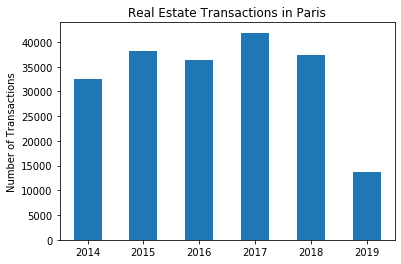

In [8]:
# Show the number of transactions per year

data = raw.copy()

# Only Paris
data = data[data['Code departement'] == '75']

# Only the sales
data = data[data['Nature mutation'] == 'Vente']

# Only the transactions with at leat one flat, house or outbuilding
data = data[
    (data['Type local'] == 'Appartement')
    | (data['Type local'] == 'Maison')
    | (data['Type local'] == 'Dépendance')
]

# Keep one row per transaction
# Remarks:
# - Rows without transaction (`nan` in the index) are automaticaly excluded by groupby()
data = data[tx_index].groupby(tx_index).head(1)

# Add year of transaction
data['!year'] = data['Date mutation'].apply(lambda dt: dt.year)

# Compute the number of transactions per year
data = data.groupby(['!year']).size()

data.plot.bar(title='Real Estate Transactions in Paris', rot=0)
plt.style.use('bmh')
plt.xlabel('')
plt.ylabel('Number of Transactions')

# free memory
del(data)